In [1]:
%load_ext autoreload
%autoreload complete --print

In [2]:
from perturb_sort import PerturbSort, normalize
import scipy, numpy as np, pandas as pd, plotly.express as px
# pd.options.plotting.backend = "plotly"
# import plotly.io as pio
# pio.renderers.default = 'svg'

In [3]:
np.random.seed()
V, B = 10, 1
dim, sparse_m = V, B
x = np.random.dirichlet(np.ones(dim))
x.sort()

# initialize a priority sampler
sims = []
seed = np.random.randint(1, 10000)
for (P, use_weights) in (
    (PerturbSort(noiser="priority", use_scipy=False), True),
    (PerturbSort(noiser="priority", use_scipy=False), False),
    (PerturbSort(noiser="expmin", use_scipy=False), True),
    (PerturbSort(noiser="expmin", use_scipy=False), False),
):
    np.random.seed(seed)
    samples = np.array([P.weighted_sample(x, sparse_m) for _ in range(10000)])
    if not use_weights:
        samples = np.array(samples!=0, dtype=float)
    sims.append({
        "name": P.noiser + str(use_weights), 
        "stats": scipy.stats.describe(samples, axis=0)
    })

df = pd.DataFrame({"Actual": x}).reset_index()
fig = px.scatter(
    df, x="Actual", y="index", labels={"Actual": "Value"},
).update_traces(marker=dict(symbol="diamond", size=15, opacity=0.4))
for i, s in enumerate(sims):
    stats = s['stats']
    fig.add_scatter(
        x=stats.mean, y=df.index -0.05*len(sims) + 0.1 * i, opacity=0.7, 
        error_x=dict(type="data", array=1.96 * np.sqrt(stats.variance / stats.nobs)),
        name=f"{s['name']}", mode="markers",
    )
fig.update_layout(plot_bgcolor="snow").show()

In [4]:
if 0:
    rng = np.random.default_rng()
    bootstrap_results = scipy.stats.bootstrap((samples,), np.mean, confidence_level=0.95, random_state=rng)
    df['m'] = np.mean(bootstrap_results.bootstrap_distribution, axis=1)
    df['CIl'] = bootstrap_results.confidence_interval.low
    df['CIh'] = bootstrap_results.confidence_interval.high
    df['se'] = bootstrap_results.standard_error
    display(df)
    fig.add_scatter(
        x=df.m,
        y=df.index,
        error_x=dict(
            array=df.CIh - df.m,
            arrayminus=df.m - df.CIl
        ),
        mode='markers',
        showlegend=False
    )
    fig.show()

The (right-skewed) "Gumbel-max trick" (or equivalently, the left-skewed Gumbel-min trick) is the same idea as the "exp-min trick", which is the same idea again as the idea in "Priority sampling". These are all basically the same algorithm, that could be called adaptive threshold sampling since they look like threshold sampling, but involve setting the threshhold adaptively, to equal the k+1 st perturbed weight [@duffield.n:2007; @daliri.m:2024].

Both you perturb your probabilities with random noise, then sort them by size, record the $(k+1)^\text{th}$ value as a threshold, and return a sample consisting of the $k$ items whose weights surpassed that threshold, and weight them by dividing the weight by an inclusion probability.

There are only two steps in the algorithm where the differences are, they are (1) where we sample a perturbed version (call it $z_i$) of each weight ($w_i$), and (2) where we calculate the inclusion probability $q_i(\tau)$ to make the importance weight for the sample, given the threshold $\tau$. That is the steps that look like this, for each $i$:

$$
\begin{aligned}
z_i &\sim \mathrm{SomeDistribution}(w_i)\\
\tau &\leftarrow \text{top/bottom-(k+1)}^\text{th}\text{ value in }\mathbf{z}\\
S &\leftarrow \{i : z_i \text{ is past threshold } \tau\}\\
q_i(\tau) &\leftarrow \Pr(z_i \text{ passes threshold} \mid \text{threshold} = \tau) 
\end{aligned}
$$

For each case (dropping the ${}_i$ subscripts):

**Priority sampling**

$$
\begin{aligned}
z &\sim\mathrm{Uniform}(\mathrm{low}=0,\mathrm{high}=\frac1w)\\
q(\tau)&\leftarrow \Pr(z < \tau) = \mathrm{CDF}_{z}(\tau)\\
         &=\mathrm{min}(1, w\cdot \tau)
\end{aligned}
$$

Now with $U\sim\mathrm{Uniform}(0,1)$ the rest are actually exactly equivalent:

**Gumbel-min**

$$
\begin{aligned}
\big(z &= \log(-\log(U)) + \log(\frac1w)\big)\\
\big(z &= -1 \cdot\mathrm{Gumbel}_r(\mathrm{loc}=\log(w),\mathrm{scale}=1)\big)\\
z &\sim \mathrm{Gumbel}_{l}(\mathrm{loc}=\log(\frac1w),\mathrm{scale}=1)\\
q(\tau)&\leftarrow \Pr(z < \tau) = \mathrm{CDF}_{z}(\tau)\\
         &=1 - e^{-e^{\log(w) + \tau}}= -\mathrm{expm1}(-w\cdot e^\tau) 
\end{aligned}
$$

(**Gumbel-max**)

$$
\begin{aligned}
\big(z &= -\log(-\log(U)) - \log(\frac1w)\big)\\
z &\sim \mathrm{Gumbel}_r(\mathrm{loc}=\log(w),\mathrm{scale}=1)\\
q(\tau)&\leftarrow \Pr(z > \tau) = 1-\mathrm{CDF}_{z}(\tau) = \mathrm{sf}_{z}(\tau)\\
         &=1-e^{-e^{\log(w)-t}} = -\mathrm{expm1}(-w\cdot e^{-\tau}) 
\end{aligned}
$$


**Exp-min**

$$
\begin{aligned}
\big(z &= -\log(U) \cdot \frac1w \big)\\
z &\sim\mathrm{Exponential}(\mathrm{scale}=\frac1w)\\
q(\tau)&\leftarrow \Pr(z < \tau) = \mathrm{CDF}_{z}(\tau)\\
         &=1-e^{-w\cdot \tau} = -\mathrm{expm1}(-w\cdot \tau) 
\end{aligned}
$$


**Beta-max**

$$
\begin{aligned}
\big(z &= U^{\frac1w} \big)\\
z &\sim\mathrm{Beta}(a=w, b=1)\\
q(\tau)&\leftarrow \Pr(z > \tau) = 1-\mathrm{CDF}_{z}(\tau) = \mathrm{sf}_{z}(\tau)\\
       &=1-\tau^w 
\end{aligned}
$$


Coding a nice common version that makes the similarities obvious, you run into one annoying thing: the Gumbel max trick uses the *top* $k$ (largest values), while the other two use *bottom* $k$ (smallest values). This means that while $q$ is the CDF in the first two cases, it is the survival function (1-CDF) in the Gumbel-max case.

Note, to make them all fit in the same pattern, we can just change the Gumbel-max to Gumbel-min. Use *negative* of our Gumbel-perturbed weights (meaning we'll have our threshold be the ${k+1}^\text{th}$ from lowest value). And then that means our $z$'s are distributed according to a so-called 'right-skewed' Gumbel distribution rather than the standard left-skewed one. 

Here's a plot of the difference. It would be easy to make the mistake of just using the same CDF, but you'd get slightly biased weights.

Here's a plot of the Gumbel left- vs right-skewed.

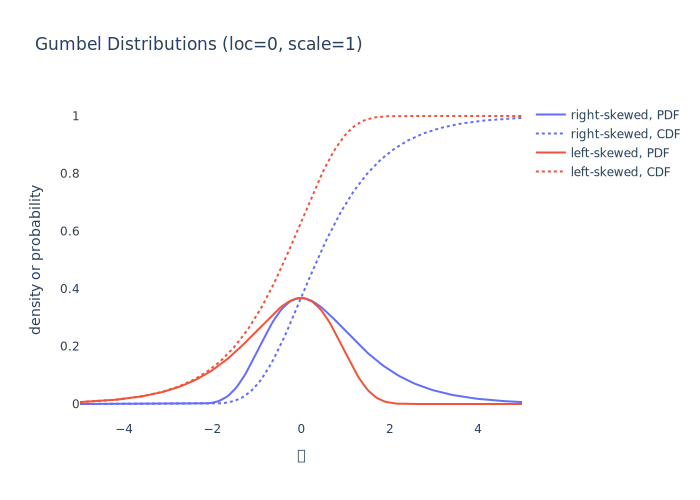

In [5]:
# Plot PDFs and CDFs of Gumbel distributions
import plotly.express as px
import numpy as np

def plot_gumbel_funcs(m=0):
    x = np.linspace(-5, 5, 200)
    # PDFs
    pdf_right = np.exp(m - x - np.exp(m - x))
    pdf_left = np.exp(-m + x - np.exp(-m + x))     
    # CDFs
    cdf_right = np.exp(-np.exp(m - x))
    cdf_left = 1 - np.exp(-np.exp(-m + x))    

    df = pd.DataFrame({
        'x': np.concatenate([x, x, x, x]),
        'y': np.concatenate([pdf_right, pdf_left, cdf_right, cdf_left]),
        'type': ['PDF']*len(x) + ['PDF']*len(x) + ['CDF']*len(x) + ['CDF']*len(x),
        'distribution': ['right-skewed']*len(x) + ['left-skewed']*len(x) + 
                       ['right-skewed']*len(x) + ['left-skewed']*len(x)
    })

    fig = px.line(df, x='x', y='y', color='distribution', line_dash='type',
                  title=f'Gumbel Distributions (loc={m}, scale=1)')

    fig.update_layout(
        xaxis_title='𝜏',
        yaxis_title='density or probability',
        legend_title=None,
        plot_bgcolor='rgba(0,0,0,0)',
        paper_bgcolor='rgba(0,0,0,0)'
    )

    return fig

# Create interactive plot with default m=0
plot_gumbel_funcs(m=0)

$$
\begin{aligned}
\mathrm{Gumbel}_r &\mathrm{pdf}(\text{loc}=m, \text{scale}=1) = e^{m-x-e^{m-x}}\\
\mathrm{Gumbel}_r &\mathrm{CDF}(\text{loc}=m, \text{scale}=1) = e^{-e^{m-x}}\\
\mathrm{Gumbel}_l &\mathrm{pdf}(\text{loc}=m, \text{scale}=1) = e^{m+x-e^{m+x}}\\
\mathrm{Gumbel}_l &\mathrm{CDF}(\text{loc}=m, \text{scale}=1) = 1-e^{-e^{m+x}}
\end{aligned}
$$